In [437]:
pip install tabula-py

In [438]:
import pandas as pd
import tabula
import numpy as np
from tabula import read_pdf
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re


In [439]:
#run only if below code gives error like [Errno 2] No such file or directory: 'C:\\Program Files\\Java\\jre1.8.0_202\\bin\\server\\jvm.dll'
# import jpype
# jpype.startJVM("C:\\Program Files\\Java\\jdk-17.0.1\\bin\\server\\jvm.dll")

# Common Extracting and preprocessing Logic 

## Extract tables

In [440]:
def extract_table_from_pdf(pdf_path, page_number, area=None, multiple_tables=False, stream=True):
    tables = read_pdf(
        pdf_path,
        pages=page_number,
        area=area,  
        multiple_tables=multiple_tables,
        stream=stream
    )

    table_df = pd.DataFrame()

    if tables:
        for i, table in enumerate(tables if isinstance(tables, list) else [tables]):
            new_headers = table.iloc[0]
            table.columns = new_headers
            table = table.drop(0).reset_index(drop=True)
            if not multiple_tables:
                return table
            else:
                table_df = pd.concat([table_df, table], ignore_index=True)
    else:
        print(f"No tables found on page {page_number}.")
    return table_df

## Page 1 

In [441]:
def raname_page1_columns(table_df, column_renames=None, unnamed_column_start=1):
    if table_df.empty:
        raise ValueError("The input DataFrame is empty.")

    table_df.columns = [
        str(i) if pd.isna(col) else col
        for i, col in enumerate(table_df.columns, start=unnamed_column_start)
    ]

    if column_renames:
        table_df = table_df.rename(columns=column_renames)

    return table_df

In [442]:

def process_and_unpivot_table_p1(table):
    table.columns = table.columns.astype(str)
    table = table.iloc[1:].reset_index(drop=True)
    table = table.applymap(lambda x: x if not isinstance(x, list) else ', '.join(map(str, x)))
    id_col = table.columns[0]
    try:
        unpivoted_table = pd.melt(
            table,
            id_vars=[id_col],
            var_name="Column Name", 
            value_name="Value"
        )
    except ValueError as e:
        print(f"Error while melting: {e}")
        print(f"Columns: {table.columns}")
        return pd.DataFrame() 

    # Add a combined text column
    unpivoted_table['text'] = unpivoted_table[id_col] + " - " + unpivoted_table["Column Name"]
    
    # Clean the 'Value' column
    unpivoted_table['Value'] = (
        unpivoted_table['Value']
        .astype(str)             
        .str.replace(r'[\$%,]', '', regex=True) 
        .str.replace('million', '', regex=False)
        .str.strip()                    
    )
    
    unpivoted_table['Value'] = unpivoted_table['Value'].replace('nan', np.NaN)
    unpivoted_table['Value'] = pd.to_numeric(unpivoted_table['Value'], errors='coerce')
    unpivoted_table = unpivoted_table[['text', 'Value']]
    
    return unpivoted_table

## Page 3 to 7

In [443]:
def split_merged_columns(table, column_index, new_column_name=None):
    data_from_column = table.iloc[:, column_index]
    header_of_column = table.columns[column_index]
    if not new_column_name:
        new_column_name = f"New {header_of_column}"
    table[new_column_name] = data_from_column

    return table

In [444]:
def format_columns(df, fourth_column_index=3, last_column_index=-1):
    fourth_column_name = df.columns[fourth_column_index]
    df[fourth_column_name] = df[fourth_column_name].astype(str).apply(
        lambda x: x.replace('$', '').replace(',', '').replace('\xa0', ' ').strip() if isinstance(x, str) else x
    )
    df[fourth_column_name] = df[fourth_column_name].apply(
        lambda x: x.split(' ')[0] if isinstance(x, str) and ' ' in x else x
    )
    last_column_name = df.columns[last_column_index]
    df[last_column_name] = df[last_column_name].astype(str).apply(
        lambda x: x.replace('$', '').replace(',', '').replace('\xa0', ' ').strip() if isinstance(x, str) else x
    )
    df[last_column_name] = df[last_column_name].apply(
        lambda x: x.split(' ')[-1] if isinstance(x, str) and ' ' in x else x
    )

    return df

In [445]:
def process_table_headers_and_convert(table_df, num_header_rows=4, handle_merged_columns=False):
    original_headers = table_df.columns.astype(str).fillna('')
    headers = table_df.iloc[:num_header_rows]
    headers = headers.fillna('')
    combined_headers = headers.apply(lambda x: ' '.join(x.astype(str)).strip(), axis=0)
    combined_headers = [
        f"{original} {combined}".strip() if original != 'nan' else combined
        for original, combined in zip(original_headers, combined_headers)
    ]
    
    filtered_columns = [
        col for col in combined_headers if col.strip() and not col.strip().startswith('Unnamed')
    ]
    
    table_df = table_df.loc[:, [col in filtered_columns for col in combined_headers]]
    table_df.columns = [
        col for col in combined_headers if col in filtered_columns
    ]
    table_df = table_df.drop(range(num_header_rows)).reset_index(drop=True)
    if handle_merged_columns:
        table_df.rename(
            columns={
                'U.S. Capital Commercial Markets Banking and Direct and Wealth Financial Management Services': 
                'U.S. Commercial Banking and Wealth Management',
                'New U.S. Capital Commercial Markets Banking and Direct and Wealth Financial Management Services': 
                'Capital Markets and Direct Financial Services'
            },
            inplace=True
        )
        table_df = format_columns(table_df)
    
    for col in table_df.columns[1:]: 
        table_df[col] = table_df[col].astype(str).str.replace(',', '', regex=False)
        table_df[col] = table_df[col].str.replace('(', '-', regex=False)
        table_df[col] = table_df[col].str.replace(')', '', regex=False)
        table_df[col] = table_df[col].str.replace('$', '', regex=False)
    
    for col in table_df.columns[1:]:  
        table_df[col] = pd.to_numeric(table_df[col], errors='coerce')
    
    return table_df

In [446]:
def melt_table_with_descriptive_text(table_df):
    if table_df.empty:
        raise ValueError("The input DataFrame is empty.")
    
    melted_df = pd.melt(
        table_df, 
        id_vars=[table_df.columns[0]],
        var_name='header', 
        value_name='value'
    )
    
    melted_df['text'] = melted_df['header'] + " - " + melted_df[table_df.columns[0]]
    melted_df = melted_df[['text', 'value']]
    
    return melted_df

In [447]:
def merge_matching_rows(df, phrases, primary_phrase, third_row_value_index=2):
    matching_rows = df[df['text'].isin(phrases)].copy() 
    matching_rows.loc[:, 'text'] = matching_rows['text'].apply(
        lambda x: x.replace(f"{primary_phrase} - ", "") if x != phrases[0] else x
    )
    combined_text = ' '.join(matching_rows['text'].unique()) 
    if matching_rows['value'].notna().any():
        combined_value = matching_rows['value'].iloc[third_row_value_index]
    else:
        combined_value = np.nan 
    combined_row = pd.DataFrame({'text': [combined_text], 'value': [combined_value]})
    updated_df = df[~df['text'].isin(phrases)]
    updated_df = pd.concat([updated_df, combined_row], ignore_index=True)

    return updated_df

In [448]:
canadian_personal_phrases = [
    "Canadian Personal and Business Banking - Recovery to income tax that will be eliminated with the substantive",
    "Canadian Personal and Business Banking - enactment of a Federal proposal to deny the dividends received",
    "Canadian Personal and Business Banking - deduction for banks (2)"
]

capital_markets_phrases = [
    "Capital Markets and Direct Financial Services - Recovery to income tax that will be eliminated with the substantive",
    "Capital Markets and Direct Financial Services - enactment of a Federal proposal to deny the dividends received",
    "Capital Markets and Direct Financial Services - deduction for banks (2)",
]

canadian_commercial_phrases = [
    "Canadian Commercial Banking and Wealth Management - Recovery to income tax that will be eliminated with the substantive",
    "Canadian Commercial Banking and Wealth Management - enactment of a Federal proposal to deny the dividends received",
    "Canadian Commercial Banking and Wealth Management - deduction for banks (2)",
]

us_commercial_phrases = [
    "U.S. Commercial Banking and Wealth Management - Recovery to income tax that will be eliminated with the substantive",
    "U.S. Commercial Banking and Wealth Management - enactment of a Federal proposal to deny the dividends received",
    "U.S. Commercial Banking and Wealth Management - deduction for banks (2)",
]

corporate_other_phrases = [
    "Corporate and Other - Recovery to income tax that will be eliminated with the substantive",
    "Corporate and Other - enactment of a Federal proposal to deny the dividends received",
    "Corporate and Other - deduction for banks (2)",
]

cibc_total_phrases = [
    "CIBC Total - Recovery to income tax that will be eliminated with the substantive",
    "CIBC Total - enactment of a Federal proposal to deny the dividends received",
    "CIBC Total - deduction for banks (2)",
]

commercial_banking_phrases = [
    "Commercial Banking and Wealth Management (US$ millions) - Recovery to income tax that will be eliminated with the substantive",
    "Commercial Banking and Wealth Management (US$ millions) - enactment of a Federal proposal to deny the dividends received",
    "Commercial Banking and Wealth Management (US$ millions) - deduction for banks (2)",
]

phrases_list = [canadian_personal_phrases, capital_markets_phrases, canadian_commercial_phrases, us_commercial_phrases, corporate_other_phrases, cibc_total_phrases, commercial_banking_phrases]
primary_phrase_list = ["Canadian Personal and Business Banking", "Capital Markets and Direct Financial Services", "Canadian Commercial Banking and Wealth Management",
                      "U.S. Commercial Banking and Wealth Management", "Corporate and Other", "CIBC Total", "Commercial Banking and Wealth Management (US$ millions)"]

In [449]:
canadian_personal_phrases = [ "Canadian Personal and Business Banking - Commodity tax charge related to the retroactive impact of the 2023",
    "Canadian Personal and Business Banking - Canadian Federal budget"
]

capital_markets_phrases = [ "Capital Markets and Direct Financial Services - Commodity tax charge related to the retroactive impact of the 2023",
    "Capital Markets and Direct Financial Services - Canadian Federal budget"
]

canadian_commercial_phrases = [ "Canadian Commercial Banking and Wealth Management - Commodity tax charge related to the retroactive impact of the 2023",
    "Canadian Commercial Banking and Wealth Management - Canadian Federal budget"
]

us_commercial_phrases = [ "U.S. Commercial Banking and Wealth Management - Commodity tax charge related to the retroactive impact of the 2023",
    "U.S. Commercial Banking and Wealth Management - Canadian Federal budget"
]

corporate_other_phrases = [ "Corporate and Other - Commodity tax charge related to the retroactive impact of the 2023",
    "Corporate and Other - Canadian Federal budget"
]

cibc_total_phrases = [ "CIBC Total - Commodity tax charge related to the retroactive impact of the 2023",
    "CIBC Total - Canadian Federal budget"
]

commercial_banking_phrases = [ "Commercial Banking and Wealth Management (US$ millions) - Commodity tax charge related to the retroactive impact of the 2023",
    "Commercial Banking and Wealth Management (US$ millions) - Canadian Federal budget"
]

q3_phrases_list = [canadian_personal_phrases, capital_markets_phrases, canadian_commercial_phrases, us_commercial_phrases, corporate_other_phrases, cibc_total_phrases, commercial_banking_phrases]
q3_primary_phrase_list = ["Canadian Personal and Business Banking", "Capital Markets and Direct Financial Services", "Canadian Commercial Banking and Wealth Management",
                      "U.S. Commercial Banking and Wealth Management", "Corporate and Other", "CIBC Total", "Commercial Banking and Wealth Management (US$ millions)"]

## Last Page

In [450]:
def process_table_headers_and_dates_for_last_page(table_df, num_header_rows=4):
    original_headers = table_df.columns.astype(str).fillna('')
    headers = table_df.iloc[:num_header_rows].fillna('')
    combined_headers = headers.apply(lambda x: ' '.join(x.astype(str)).strip(), axis=0)
    combined_headers = [
        f"{original} {combined}".strip() if original != 'nan' else combined
        for original, combined in zip(original_headers, combined_headers)
    ]
    table_df.columns = combined_headers
    table_df = table_df.drop(range(num_header_rows)).reset_index(drop=True)

    filtered_columns = [
        col for col in table_df.columns if col.strip() and not col.strip().startswith('Unnamed')
    ]
    table_df = table_df.loc[:, filtered_columns]
    
    table_df['Year'] = table_df.iloc[:, 0].str.extract(r'(\d{4})') 
    table_df['Year'] = table_df['Year'].fillna(method='ffill') 
    table_df['Month_Day'] = table_df.iloc[:, 0].str.extract(r'([A-Za-z]+\.? \d{1,2})')
    table_df['Date'] = (table_df['Year'] + ' ' + table_df['Month_Day']).str.strip() 
    
    table_df.iloc[:, 0] = table_df.iloc[:, 0].str.replace(r'(\d{4})', '', regex=True)
    table_df.iloc[:, 0] = table_df.iloc[:, 0].str.replace(r'([A-Za-z]+\.? \d{1,2})', '', regex=True) 
    table_df.iloc[:, 0] = table_df.iloc[:, 0].str.strip()
    
    table_df.drop(columns=['Year', 'Month_Day'], inplace=True)

    for col in table_df.columns[1:]: 
        if col != 'Date': 
            table_df[col] = table_df[col].astype(str).str.replace(',', '', regex=False)
            table_df[col] = table_df[col].str.replace('(', '-', regex=False)
            table_df[col] = table_df[col].str.replace(')', '', regex=False)
            table_df[col] = table_df[col].str.replace('$', '', regex=False)
            table_df[col] = pd.to_numeric(table_df[col], errors='coerce')

    return table_df


In [451]:
def process_and_melt_table_with_date(table_df, date_column='Date', date_replacements=None):
    if table_df.empty:
        raise ValueError("The input DataFrame is empty.")

    if date_column not in table_df.columns:
        raise ValueError(f"The specified date column '{date_column}' does not exist in the DataFrame.")

    melted_df = pd.melt(
        table_df,
        id_vars=[table_df.columns[0], date_column],
        var_name='header',
        value_name='value'
    )
    
    melted_df['text'] = melted_df['header'] + " - " + melted_df[table_df.columns[0]]
    melted_df = melted_df[['Date', 'text', 'value']]
    if date_replacements:
        melted_df['Date'] = melted_df['Date'].replace(date_replacements)

    rows = len(melted_df)
    for i in range(rows):
        if i == 0 and pd.isna(melted_df.loc[i, date_column]):
            melted_df.loc[i, date_column] = melted_df.loc[i + 1, date_column]
        
        elif pd.isna(melted_df.loc[i, date_column]):
            if i == rows - 1:
                melted_df.loc[i, date_column] = melted_df.loc[i - 1, date_column]
            elif not pd.isna(melted_df.loc[i + 1, date_column]):
                melted_df.loc[i, date_column] = melted_df.loc[i + 1, date_column]
            else:
                melted_df.loc[i, date_column] = melted_df.loc[i - 1, date_column]
    melted_df['text'] =  melted_df['text'] + " - " + melted_df['Date'] 

    melted_df.drop(columns = 'Date', inplace = True)

    return melted_df

# 2024

## Q3 2024

In [452]:
pdf_path = 'q324newsrelease-en.pdf'

q324_processed_table_page_1 = extract_table_from_pdf(pdf_path, 1, [155, 20, 290, 576])
q324_processed_table_page_3 = extract_table_from_pdf(pdf_path, 3, [210, 20, 610, 800])
q324_processed_table_page_4 = extract_table_from_pdf(pdf_path, 4)
q324_processed_table_page_5 = extract_table_from_pdf(pdf_path, 5)
q324_processed_table_page_6 = extract_table_from_pdf(pdf_path, 6)
q324_processed_table_page_7 = extract_table_from_pdf(pdf_path, 7) 
q324_processed_table_page_8 = extract_table_from_pdf(pdf_path, 8, [70, 20, 420, 800])

### Q3 2024 - Page 1

In [453]:
column_renames = {
    'Q3/24': 'Q3 2024',
    'Q3/23 (1)': 'Q3 2023',
    'Q2/24': 'Q2 2024',
    '1': 'text',
    '5': 'YoY Variance',
    '6': 'QoQ Variance',
}

q324_processed_table_page_1 = raname_page1_columns(
    table_df=q324_processed_table_page_1,
    column_renames=column_renames,
    unnamed_column_start=1
)

q324_processed_df_page_1 = process_and_unpivot_table_p1(q324_processed_table_page_1)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\1073757183.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = table.applymap(lambda x: x if not isinstance(x, list) else ', '.join(map(str, x)))


### Q3 2024 - Page 3 to 7

In [454]:
canadian_personal_phrases = [ "Canadian Personal and Business Banking - Adjustments related to enactment of a Federal tax measure in June",
    "Canadian Personal and Business Banking - 2024 that denies the dividends received deduction for banks (2)"
]

capital_markets_phrases = [ "Capital Markets and Direct Financial Services - Adjustments related to enactment of a Federal tax measure in June",
    "Capital Markets and Direct Financial Services - 2024 that denies the dividends received deduction for banks (2)"
]

canadian_commercial_phrases = [ "Canadian Commercial Banking and Wealth Management - Adjustments related to enactment of a Federal tax measure in June",
    "Canadian Commercial Banking and Wealth Management - 2024 that denies the dividends received deduction for banks (2)"
]

us_commercial_phrases = [ "U.S. Commercial Banking and Wealth Management - Adjustments related to enactment of a Federal tax measure in June",
    "U.S. Commercial Banking and Wealth Management - 2024 that denies the dividends received deduction for banks (2)"
]

corporate_other_phrases = [ "Corporate and Other - Adjustments related to enactment of a Federal tax measure in June",
    "Corporate and Other - 2024 that denies the dividends received deduction for banks (2)"
]

cibc_total_phrases = [ "CIBC Total - Adjustments related to enactment of a Federal tax measure in June",
    "CIBC Total - 2024 that denies the dividends received deduction for banks (2)"
]

commercial_banking_phrases = [ "Commercial Banking and Wealth Management (US$ millions) - Adjustments related to enactment of a Federal tax measure in June",
    "Commercial Banking and Wealth Management (US$ millions) - 2024 that denies the dividends received deduction for banks (2)"
]

phrases_list_p3_p6 = [canadian_personal_phrases, capital_markets_phrases, canadian_commercial_phrases, us_commercial_phrases, 
                   corporate_other_phrases, cibc_total_phrases, commercial_banking_phrases]

primary_phrase_list_p3_p6 = ["Canadian Personal and Business Banking", "Capital Markets and Direct Financial Services", 
                          "Canadian Commercial Banking and Wealth Management", "U.S. Commercial Banking and Wealth Management",
                          "Corporate and Other", "CIBC Total", "Commercial Banking and Wealth Management (US$ millions)"]

In [455]:
q324_processed_table_page_3 = split_merged_columns(q324_processed_table_page_3, column_index=3)
q324_processed_table_page_6 = split_merged_columns(q324_processed_table_page_6, column_index=3)

q324_processed_df_page_3 = process_table_headers_and_convert(q324_processed_table_page_3, num_header_rows=4, handle_merged_columns=True)
q324_processed_df_page_4 = process_table_headers_and_convert(q324_processed_table_page_4, num_header_rows=4)
q324_processed_df_page_5 = process_table_headers_and_convert(q324_processed_table_page_5, num_header_rows=4)
q324_processed_df_page_6 = process_table_headers_and_convert(q324_processed_table_page_6, num_header_rows=4, handle_merged_columns=True)
q324_processed_df_page_7 = process_table_headers_and_convert(q324_processed_table_page_7, num_header_rows=4)

q324_processed_df_page_3 = melt_table_with_descriptive_text(q324_processed_df_page_3)
q324_processed_df_page_4 = melt_table_with_descriptive_text(q324_processed_df_page_4)
q324_processed_df_page_5 = melt_table_with_descriptive_text(q324_processed_df_page_5)
q324_processed_df_page_6 = melt_table_with_descriptive_text(q324_processed_df_page_6)
q324_processed_df_page_7 = melt_table_with_descriptive_text(q324_processed_df_page_7)

for phrase, primary_phrase in zip(phrases_list, primary_phrase_list):
    q324_processed_df_page_4 = merge_matching_rows(q324_processed_df_page_4, phrase, primary_phrase=primary_phrase)

for phrase, primary_phrase in zip(phrases_list_p3_p6, primary_phrase_list_p3_p6):
    q324_processed_df_page_3 = merge_matching_rows(q324_processed_df_page_3, phrase, primary_phrase=primary_phrase)
    q324_processed_df_page_6= merge_matching_rows(q324_processed_df_page_6, phrase, primary_phrase=primary_phrase)

for phrase, primary_phrase in zip(q3_phrases_list, q3_primary_phrase_list):
    q324_processed_df_page_5 = merge_matching_rows(q324_processed_df_page_5, phrase, primary_phrase=primary_phrase)
    q324_processed_df_page_7= merge_matching_rows(q324_processed_df_page_7, phrase, primary_phrase=primary_phrase)

q324_processed_df_page_3['text'] = q324_processed_df_page_3['text'].astype(str) + 'Q3 2024 three months end'
q324_processed_df_page_4['text'] = q324_processed_df_page_4['text'].astype(str) + 'Q2 2024 three months end'
q324_processed_df_page_5['text'] = q324_processed_df_page_5['text'].astype(str) + 'Q3 2023 three months end'
q324_processed_df_page_6['text'] = q324_processed_df_page_6['text'].astype(str) + 'Q3 2024 nine months end'
q324_processed_df_page_7['text'] = q324_processed_df_page_7['text'].astype(str) + 'Q3 2023 nine months end'

### Q3 2024 - Page 8

In [456]:
q324_processed_df_page_8 = process_table_headers_and_dates_for_last_page(q324_processed_table_page_8, num_header_rows=4)

date_replacements = {
    'nan': np.nan,  
    '2024 Jul. 31': 'Q3 2024',
    '2024 Apr. 30': 'Q2 2024',
    '2023 Jul. 31': 'Q3 2023',
}

q324_processed_df_page_8 = process_and_melt_table_with_date(
    table_df=q324_processed_df_page_8,
    date_column='Date',
    date_replacements=date_replacements
)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\2005604776.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table_df['Year'] = table_df['Year'].fillna(method='ffill')


### Merging the final test df

In [457]:


dataframes_test = [
    q324_processed_df_page_1,
    q324_processed_df_page_3,
    q324_processed_df_page_4,
    q324_processed_df_page_5,
    q324_processed_df_page_6,
    q324_processed_df_page_7,
    q324_processed_df_page_8
]

def format_column_names(df_list):
    for df in df_list:
        df.columns = df.columns.str.strip().str.lower()

format_column_names(dataframes_test)
test_df_q32024 = pd.concat(dataframes_test, ignore_index=True)
print("Combined test_df_q32024 shape:", test_df_q32024.shape)


Combined test_df_q32024 shape: (1568, 2)


In [458]:
test_df_q32024

,text,value
0,Revenue - Q3 2024,6604.00
1,Reported Net Income - Q3 2024,1795.00
2,Adjusted Net Income (2) - Q3 2024,1895.00
3,"Adjusted pre-provision, pre-tax earnings (2) -...",2939.00
4,Reported Diluted Earnings Per Share (EPS) - Q3...,1.82
...,...,...
1563,Commercial Banking and Wealth Management (US$ ...,447.00
1564,Commercial Banking and Wealth Management (US$ ...,8.00
1565,Commercial Banking and Wealth Management (US$ ...,700.00
1566,Commercial Banking and Wealth Management (US$ ...,35.00


## Q2 2024

### Table Extraction

In [459]:
pdf_path = 'q224newsrelease-en.pdf'
page_3_area = [300, 20, 610, 800]

q224_processed_table_page_1 = extract_table_from_pdf(pdf_path, 1)
q224_processed_table_page_3 = extract_table_from_pdf(pdf_path, 3, page_3_area)
q224_processed_table_page_4 = extract_table_from_pdf(pdf_path, 4)
q224_processed_table_page_5 = extract_table_from_pdf(pdf_path, 5)
q224_processed_table_page_6 = extract_table_from_pdf(pdf_path, 6)
q224_processed_table_page_7 = extract_table_from_pdf(pdf_path, 7)
q224_processed_table_page_8 = extract_table_from_pdf(pdf_path, 8)

### Q2 2024 - Page 1

In [460]:
column_renames = {
    'Q2/24': 'Q2 2024',
    'Q2/23 (1)': 'Q2 2023',
    'Q1/24': 'Q1 2024',
    '1': 'text',
    '5': 'YoY Variance',
    '6': 'QoQ Variance',
}

q224_processed_table_page_1 = raname_page1_columns(
    table_df=q224_processed_table_page_1,
    column_renames=column_renames,
    unnamed_column_start=1
)
q224_processed_df_page_1 = process_and_unpivot_table_p1(q224_processed_table_page_1)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\1073757183.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = table.applymap(lambda x: x if not isinstance(x, list) else ', '.join(map(str, x)))


### Q2 2024 - Page 3 to 7

In [461]:
q224_processed_table_page_3 = split_merged_columns(q224_processed_table_page_3, column_index=3)
q224_processed_table_page_6 = split_merged_columns(q224_processed_table_page_6, column_index=3)

q224_processed_df_page_3 = process_table_headers_and_convert(q224_processed_table_page_3, num_header_rows=4, handle_merged_columns=True)
q224_processed_df_page_4 = process_table_headers_and_convert(q224_processed_table_page_4, num_header_rows=4)
q224_processed_df_page_5 = process_table_headers_and_convert(q224_processed_table_page_5, num_header_rows=4)
q224_processed_df_page_6 = process_table_headers_and_convert(q224_processed_table_page_6, num_header_rows=4, handle_merged_columns=True)
q224_processed_df_page_7 = process_table_headers_and_convert(q224_processed_table_page_7, num_header_rows=4)

q224_processed_df_page_3 = melt_table_with_descriptive_text(q224_processed_df_page_3)
q224_processed_df_page_4 = melt_table_with_descriptive_text(q224_processed_df_page_4)
q224_processed_df_page_5 = melt_table_with_descriptive_text(q224_processed_df_page_5)
q224_processed_df_page_6 = melt_table_with_descriptive_text(q224_processed_df_page_6)
q224_processed_df_page_7 = melt_table_with_descriptive_text(q224_processed_df_page_7)

for phrase, primary_phrase in zip(phrases_list, primary_phrase_list):
    q224_processed_df_page_3 = merge_matching_rows(q224_processed_df_page_3, phrase, primary_phrase=primary_phrase)
    q224_processed_df_page_4 = merge_matching_rows(q224_processed_df_page_4, phrase, primary_phrase=primary_phrase)
    q224_processed_df_page_6 = merge_matching_rows(q224_processed_df_page_6, phrase, primary_phrase=primary_phrase)


q224_processed_df_page_3['text'] = q224_processed_df_page_3['text'].astype(str) + 'Q2 2024 three months end'
q224_processed_df_page_4['text'] = q224_processed_df_page_4['text'].astype(str) + 'Q1 2024 three months end'
q224_processed_df_page_5['text'] = q224_processed_df_page_5['text'].astype(str) + 'Q2 2023 three months end'
q224_processed_df_page_6['text'] = q224_processed_df_page_6['text'].astype(str) + 'Q2 2024 six months end'
q224_processed_df_page_7['text'] = q224_processed_df_page_7['text'].astype(str) + 'Q2 2023 six months end'

### Q2 2024 - Page 8

In [462]:
q224_processed_df_page_8 = process_table_headers_and_dates_for_last_page(q224_processed_table_page_8, num_header_rows=4)

date_replacements = {
    'nan': np.nan, 
    '2024 Apr. 30': 'Q2 2024',
    '2024 Jan. 31': 'Q1 2024',
    '2023 Apr. 30': 'Q2 2023'
}

q224_processed_df_page_8 = process_and_melt_table_with_date(
    table_df=q224_processed_df_page_8,
    date_column='Date',
    date_replacements=date_replacements
)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\2005604776.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table_df['Year'] = table_df['Year'].fillna(method='ffill')


## Q1 2024

In [463]:
pdf_path = 'q124newsrelease-en.pdf' 

q124_processed_table_page_1 = extract_table_from_pdf(pdf_path, 1, [145, 30, 310, 576])
q124_processed_table_page_3 = extract_table_from_pdf(pdf_path, 3, [210, 20, 610, 800])
q124_processed_table_page_4 = extract_table_from_pdf(pdf_path, 4, [60, 30, 370, 600])
q124_processed_table_page_4_2 = extract_table_from_pdf(pdf_path, 4, [400, 30, 740, 600])
q124_processed_table_page_5 = extract_table_from_pdf(pdf_path, 5, [70, 30, 290, 600])

### Q1 2024 - Page 1

In [464]:
column_renames = {
    'Q1/24': 'Q1 2024',
    'Q1/23 (1)	': 'Q1 2023',
    'Q4/23 (1)': 'Q4 2023',
    '1': 'text',
    '5': 'YoY Variance',
    '6': 'QoQ Variance',
}

q124_processed_table_page_1 = raname_page1_columns(
    table_df=q124_processed_table_page_1,
    column_renames=column_renames,
    unnamed_column_start=1
)

q124_processed_df_page_1 = process_and_unpivot_table_p1(q124_processed_table_page_1)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\1073757183.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = table.applymap(lambda x: x if not isinstance(x, list) else ', '.join(map(str, x)))


### Q1 2024 - Page 3 - 4

In [465]:
q124_processed_table_page_3 = split_merged_columns(q124_processed_table_page_3, column_index=3)

q124_processed_df_page_3 = process_table_headers_and_convert(q124_processed_table_page_3, num_header_rows=4, handle_merged_columns=True)
q124_processed_df_page_4 = process_table_headers_and_convert(q124_processed_table_page_4, num_header_rows=4)
q124_processed_df_page_4_2 = process_table_headers_and_convert(q124_processed_table_page_5, num_header_rows=4)

q124_processed_df_page_3 = melt_table_with_descriptive_text(q124_processed_df_page_3)
q124_processed_df_page_4 = melt_table_with_descriptive_text(q124_processed_df_page_4)
q124_processed_df_page_4_2 = melt_table_with_descriptive_text(q124_processed_df_page_4_2)

q124_processed_df_page_3['text'] = q124_processed_df_page_3['text'].astype(str) + 'Q1 2024 three months end'
q124_processed_df_page_4['text'] = q124_processed_df_page_4['text'].astype(str) + 'Q4 2023 three months end'
q124_processed_df_page_4_2['text'] = q124_processed_df_page_4_2['text'].astype(str) + 'Q1 2023 three months end'

### Q1 2024 - Page 5

In [466]:
q124_processed_df_page_5 = process_table_headers_and_dates_for_last_page(q124_processed_table_page_5, num_header_rows=4)

date_replacements = {
    'nan': np.nan,
    '2024 Jan. 31': 'Q1 2024',
    '2023 Oct. 31': 'Q4 2023',
    '2023 Jan. 31': 'Q1 2023'
}

q124_processed_df_page_5 = process_and_melt_table_with_date(
    table_df=q124_processed_df_page_5,
    date_column='Date',
    date_replacements=date_replacements
)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\2005604776.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table_df['Year'] = table_df['Year'].fillna(method='ffill')


# 2023

## Q3 2023

### Table Extraction

In [467]:
pdf_path = 'q323newsrelease-en.pdf'

q323_processed_table_page_1 = extract_table_from_pdf(pdf_path, 1, [155, 20, 290, 576])
q323_processed_table_page_3 = extract_table_from_pdf(pdf_path, 3, [210, 20, 610, 800])
q323_processed_table_page_4 = extract_table_from_pdf(pdf_path, 4)
q323_processed_table_page_5 = extract_table_from_pdf(pdf_path, 5)
q323_processed_table_page_6 = extract_table_from_pdf(pdf_path, 6)
q323_processed_table_page_7 = extract_table_from_pdf(pdf_path, 7)
q323_processed_table_page_8 = extract_table_from_pdf(pdf_path, 8)

### Q3 2023 - Page 1

In [468]:
column_renames = {
    'Q3/23': 'Q3 2023',
    'Q3/22': 'Q3 2022',
    'Q2/23': 'Q2 2023',
    '1': 'text',
    '5': 'YoY Variance',
    '6': 'QoQ Variance',
}

q323_processed_table_page_1 = raname_page1_columns(
    table_df=q323_processed_table_page_1,
    column_renames=column_renames,
    unnamed_column_start=1
)
q323_processed_df_page_1 = process_and_unpivot_table_p1(q323_processed_table_page_1)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\1073757183.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = table.applymap(lambda x: x if not isinstance(x, list) else ', '.join(map(str, x)))


### Q3 2023 - Page 3 to 7

In [469]:
canadian_personal_phrases = [ "Canadian Personal and Business Banking - Acquisition and integration-related costs as well as purchase",
    "Canadian Personal and Business Banking - accounting adjustments (5)"
]

capital_markets_phrases = [ "Capital Markets and Direct Financial Services - Acquisition and integration-related costs as well as purchase",
    "Capital Markets and Direct Financial Services - accounting adjustments (5)"
]

canadian_commercial_phrases = [ "Canadian Commercial Banking and Wealth Management - Acquisition and integration-related costs as well as purchase",
    "Canadian Commercial Banking and Wealth Management - accounting adjustments (5)"
]

us_commercial_phrases = [ "U.S. Commercial Banking and Wealth Management - Acquisition and integration-related costs as well as purchase",
    "U.S. Commercial Banking and Wealth Management - accounting adjustments (5)"
]

corporate_other_phrases = [ "Corporate and Other - Acquisition and integration-related costs as well as purchase",
    "Corporate and Other - accounting adjustments (5)"
]

cibc_total_phrases = [ "CIBC Total - Acquisition and integration-related costs as well as purchase",
    "CIBC Total - accounting adjustments (5)"
]

commercial_banking_phrases = [ "Commercial Banking and Wealth Management (US$ millions) - Acquisition and integration-related costs as well as purchase",
    "Commercial Banking and Wealth Management (US$ millions) - accounting adjustments (5)"
]

phrases_list_p5 = [canadian_personal_phrases, capital_markets_phrases, canadian_commercial_phrases, us_commercial_phrases, corporate_other_phrases, cibc_total_phrases, commercial_banking_phrases]
primary_phrase_list_p5 = ["Canadian Personal and Business Banking", "Capital Markets and Direct Financial Services", "Canadian Commercial Banking and Wealth Management",
                      "U.S. Commercial Banking and Wealth Management", "Corporate and Other", "CIBC Total", "Commercial Banking and Wealth Management (US$ millions)"]

In [470]:
q323_processed_df_page_3 = process_table_headers_and_convert(q323_processed_table_page_3, num_header_rows=4)
q323_processed_df_page_4 = process_table_headers_and_convert(q323_processed_table_page_4, num_header_rows=4)
q323_processed_df_page_5 = process_table_headers_and_convert(q323_processed_table_page_5, num_header_rows=4)
q323_processed_df_page_6 = process_table_headers_and_convert(q323_processed_table_page_6, num_header_rows=4)
q323_processed_df_page_7 = process_table_headers_and_convert(q323_processed_table_page_7, num_header_rows=4)

q323_processed_df_page_3 = melt_table_with_descriptive_text(q323_processed_df_page_3)
q323_processed_df_page_4 = melt_table_with_descriptive_text(q323_processed_df_page_4)
q323_processed_df_page_5 = melt_table_with_descriptive_text(q323_processed_df_page_5)
q323_processed_df_page_6 = melt_table_with_descriptive_text(q323_processed_df_page_6)
q323_processed_df_page_7 = melt_table_with_descriptive_text(q323_processed_df_page_7)

for phrase, primary_phrase in zip(q3_phrases_list, q3_primary_phrase_list):
    q323_processed_df_page_3 = merge_matching_rows(q323_processed_df_page_3, phrase, primary_phrase=primary_phrase)

for phrase, primary_phrase in zip(phrases_list_p5, primary_phrase_list_p5):
    q323_processed_df_page_5 = merge_matching_rows(q323_processed_df_page_5, phrase, primary_phrase=primary_phrase)

q323_processed_df_page_3['text'] = q323_processed_df_page_3['text'].astype(str) + 'Q3 2023 three months end'
q323_processed_df_page_4['text'] = q323_processed_df_page_4['text'].astype(str) + 'Q2 2023 three months end'
q323_processed_df_page_5['text'] = q323_processed_df_page_5['text'].astype(str) + 'Q3 2022 three months end'
q323_processed_df_page_6['text'] = q323_processed_df_page_6['text'].astype(str) + 'Q3 2023 nine months end'
q323_processed_df_page_7['text'] = q323_processed_df_page_7['text'].astype(str) + 'Q3 2022 nine months end'

### Q3 2023 - Page 8

In [471]:
q323_processed_df_page_8 = process_table_headers_and_dates_for_last_page(q323_processed_table_page_8, num_header_rows=4)

date_replacements = {
    'nan': np.nan, 
    '2023 Jul. 31': 'Q3 2023',
    '2023 Apr. 30': 'Q2 2023',
    '2022 Jul. 31': 'Q3 2022',
}

q323_processed_df_page_8 = process_and_melt_table_with_date(
    table_df=q323_processed_df_page_8,
    date_column='Date',
    date_replacements=date_replacements
)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\2005604776.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table_df['Year'] = table_df['Year'].fillna(method='ffill')


## Q2 2023

In [472]:
pdf_path = 'q223newsrelease-en.pdf'

q223_processed_table_page_1 = extract_table_from_pdf(pdf_path, 1, [170, 20, 290, 576])
q223_processed_table_page_3 = extract_table_from_pdf(pdf_path, 3, [210, 20, 610, 800])
q223_processed_table_page_4 = extract_table_from_pdf(pdf_path, 4)
q223_processed_table_page_5 = extract_table_from_pdf(pdf_path, 5)
q223_processed_table_page_6 = extract_table_from_pdf(pdf_path, 6)
q223_processed_table_page_7 = extract_table_from_pdf(pdf_path, 7)
q223_processed_table_page_8 = extract_table_from_pdf(pdf_path, 8,[70, 20, 420, 800])

### Q2 2023 - Page 1

In [473]:
column_renames = {
    'Q2/23': 'Q2 2023',
    'Q2/22': 'Q2 2022',
    'Q1/23': 'Q1 2023',
    '1': 'text',
    '5': 'YoY Variance',
    '6': 'QoQ Variance',
}

q223_processed_table_page_1 = raname_page1_columns(
    table_df=q223_processed_table_page_1,
    column_renames=column_renames,
    unnamed_column_start=1
)
q223_processed_df_page_1 = process_and_unpivot_table_p1(q223_processed_table_page_1)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\1073757183.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = table.applymap(lambda x: x if not isinstance(x, list) else ', '.join(map(str, x)))


### Q2 2023 - Page 3 to 7

In [474]:
canadian_personal_phrases = [
    "Canadian Personal and Business Banking - Acquisition and integration-related costs as well as purchase",
    "Canadian Personal and Business Banking - accounting adjustments and provision for credit losses for",
    "Canadian Personal and Business Banking - deduction for banks (2)"
]

capital_markets_phrases = [
    "Capital Markets and Direct Financial Services - Acquisition and integration-related costs as well as purchase",
    "Capital Markets and Direct Financial Services - accounting adjustments and provision for credit losses for",
    "Capital Markets and Direct Financial Services - deduction for banks (2)",
]

canadian_commercial_phrases = [
    "Canadian Commercial Banking and Wealth Management - Acquisition and integration-related costs as well as purchase",
    "Canadian Commercial Banking and Wealth Management - accounting adjustments and provision for credit losses for",
    "Canadian Commercial Banking and Wealth Management - performing loans (6)",
]

us_commercial_phrases = [
    "U.S. Commercial Banking and Wealth Management - Acquisition and integration-related costs as well as purchase",
    "U.S. Commercial Banking and Wealth Management - accounting adjustments and provision for credit losses for",
    "U.S. Commercial Banking and Wealth Management - performing loans (6)",
]

corporate_other_phrases = [
    "Corporate and Other - Acquisition and integration-related costs as well as purchase",
    "Corporate and Other - accounting adjustments and provision for credit losses for",
    "Corporate and Other - performing loans (6)",
]

cibc_total_phrases = [
    "CIBC Total - Acquisition and integration-related costs as well as purchase",
    "CIBC Total - accounting adjustments and provision for credit losses for",
    "CIBC Total - performing loans (6)",
]

commercial_banking_phrases = [
    "Commercial Banking and Wealth Management (US$ millions) - Acquisition and integration-related costs as well as purchase",
    "Commercial Banking and Wealth Management (US$ millions) - accounting adjustments and provision for credit losses for",
    "Commercial Banking and Wealth Management (US$ millions) - performing loans (6)",
]

phrases_list_q223 = [canadian_personal_phrases, capital_markets_phrases, canadian_commercial_phrases, us_commercial_phrases, corporate_other_phrases, cibc_total_phrases, commercial_banking_phrases]
primary_phrase_list_q223 = ["Canadian Personal and Business Banking", "Capital Markets and Direct Financial Services", "Canadian Commercial Banking and Wealth Management",
                      "U.S. Commercial Banking and Wealth Management", "Corporate and Other", "CIBC Total", "Commercial Banking and Wealth Management (US$ millions)"]

In [475]:
q223_processed_df_page_3 = process_table_headers_and_convert(q223_processed_table_page_3, num_header_rows=4)
q223_processed_df_page_4 = process_table_headers_and_convert(q223_processed_table_page_4, num_header_rows=4)
q223_processed_df_page_5 = process_table_headers_and_convert(q223_processed_table_page_5, num_header_rows=4)
q223_processed_df_page_6 = process_table_headers_and_convert(q223_processed_table_page_6, num_header_rows=4)
q223_processed_df_page_7 = process_table_headers_and_convert(q223_processed_table_page_7, num_header_rows=4)

q223_processed_df_page_3 = melt_table_with_descriptive_text(q223_processed_df_page_3)
q223_processed_df_page_4 = melt_table_with_descriptive_text(q223_processed_df_page_4)
q223_processed_df_page_5 = melt_table_with_descriptive_text(q223_processed_df_page_5)
q223_processed_df_page_6 = melt_table_with_descriptive_text(q223_processed_df_page_6)
q223_processed_df_page_7 = melt_table_with_descriptive_text(q223_processed_df_page_7)

for phrase, primary_phrase in zip(phrases_list_q223, primary_phrase_list_q223):
    q223_processed_df_page_5 = merge_matching_rows(q223_processed_df_page_5, phrase, primary_phrase=primary_phrase)

for phrase, primary_phrase in zip(phrases_list_q223, primary_phrase_list_q223):
    q223_processed_df_page_7 = merge_matching_rows(q223_processed_df_page_7, phrase, primary_phrase=primary_phrase)

q223_processed_df_page_3['text'] = q223_processed_df_page_3['text'].astype(str) + 'Q2 2023 three months end'
q223_processed_df_page_4['text'] = q223_processed_df_page_4['text'].astype(str) + 'Q1 2023 three months end'
q223_processed_df_page_5['text'] = q223_processed_df_page_5['text'].astype(str) + 'Q2 2022 three months end'
q223_processed_df_page_6['text'] = q223_processed_df_page_6['text'].astype(str) + 'Q2 2023 six months end'
q223_processed_df_page_7['text'] = q223_processed_df_page_7['text'].astype(str) + 'Q2 2022 six months end'

### Q2 2023 - Page 8

In [476]:
q223_processed_df_page_8 = process_table_headers_and_dates_for_last_page(q223_processed_table_page_8, num_header_rows=4)

date_replacements = {
    'nan': np.nan, 
    '2023 Apr. 30': 'Q2 2023',
    '2023 Jan. 31': 'Q1 2023',
    '2022 Apr. 31': 'Q2 2022',
}

q223_processed_df_page_8 = process_and_melt_table_with_date(
    table_df=q223_processed_df_page_8,
    date_column='Date',
    date_replacements=date_replacements
)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\2005604776.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table_df['Year'] = table_df['Year'].fillna(method='ffill')


## Q1 2023

In [477]:
pdf_path = 'q123newsrelease-en.pdf'

q123_processed_table_page_1 = extract_table_from_pdf(pdf_path, 1, [160, 20, 290, 576])
q123_processed_table_page_3 = extract_table_from_pdf(pdf_path, 3, [210, 20, 610, 800])
q123_processed_table_page_4 = extract_table_from_pdf(pdf_path, 4)
q123_processed_table_page_5 = extract_table_from_pdf(pdf_path, 5, [60, 30, 390, 600])
q123_processed_table_page_5_2 = extract_table_from_pdf(pdf_path, 5, [420, 30, 650, 600])

### Q1 2023 - Page 1

In [478]:
column_renames = {
    'Q1/23': 'Q1 2023',
    'Q1/22': 'Q1 2022',
    'Q4/22': 'Q4 2022',
    '1': 'text',
    '5': 'YoY Variance',
    '7': 'QoQ Variance',
}

q123_processed_table_page_1 = raname_page1_columns(
    table_df=q123_processed_table_page_1,
    column_renames=column_renames,
    unnamed_column_start=1
)

q123_processed_table_page_1.drop(columns='6', inplace = True)
q123_processed_df_page_1 = process_and_unpivot_table_p1(q123_processed_table_page_1)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\1073757183.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = table.applymap(lambda x: x if not isinstance(x, list) else ', '.join(map(str, x)))


### Q1 2023 - Page 3 to 5(table 1)

In [479]:
canadian_personal_phrases = [ "Canadian Personal and Business Banking - Acquisition and integration-related costs as well as purchase",
    "Canadian Personal and Business Banking - accounting adjustments (6)"
]

capital_markets_phrases = [ "Capital Markets and Direct Financial Services - Acquisition and integration-related costs as well as purchase",
    "Capital Markets and Direct Financial Services - accounting adjustments (6)"
]

canadian_commercial_phrases = [ "Canadian Commercial Banking and Wealth Management - Acquisition and integration-related costs as well as purchase",
    "Canadian Commercial Banking and Wealth Management - accounting adjustments (6)"
]

us_commercial_phrases = [ "U.S. Commercial Banking and Wealth Management - Acquisition and integration-related costs as well as purchase",
    "U.S. Commercial Banking and Wealth Management - accounting adjustments (6)"
]

corporate_other_phrases = [ "Corporate and Other - Acquisition and integration-related costs as well as purchase",
    "Corporate and Other - accounting adjustments (6)"
]

cibc_total_phrases = [ "CIBC Total - Acquisition and integration-related costs as well as purchase",
    "CIBC Total - accounting adjustments (6)"
]

commercial_banking_phrases = [ "Commercial Banking and Wealth Management (US$ millions) - Acquisition and integration-related costs as well as purchase",
    "Commercial Banking and Wealth Management (US$ millions) - accounting adjustments (6)"
]

phrases_list_p4 = [canadian_personal_phrases, capital_markets_phrases, canadian_commercial_phrases, us_commercial_phrases, corporate_other_phrases, cibc_total_phrases, commercial_banking_phrases]
primary_phrase_list_p4 = ["Canadian Personal and Business Banking", "Capital Markets and Direct Financial Services", "Canadian Commercial Banking and Wealth Management",
                      "U.S. Commercial Banking and Wealth Management", "Corporate and Other", "CIBC Total", "Commercial Banking and Wealth Management (US$ millions)"]

In [480]:
q123_processed_df_page_3 = process_table_headers_and_convert(q123_processed_table_page_3, num_header_rows=4)
q123_processed_df_page_4 = process_table_headers_and_convert(q123_processed_table_page_4, num_header_rows=4)
q123_processed_df_page_5 = process_table_headers_and_convert(q123_processed_table_page_5, num_header_rows=4)

q123_processed_df_page_3 = melt_table_with_descriptive_text(q123_processed_df_page_3)
q123_processed_df_page_4 = melt_table_with_descriptive_text(q123_processed_df_page_4)
q123_processed_df_page_5 = melt_table_with_descriptive_text(q123_processed_df_page_5)

for phrase, primary_phrase in zip(phrases_list_p4, primary_phrase_list_p4):
    q123_processed_df_page_4 = merge_matching_rows(q123_processed_df_page_4, phrase, primary_phrase=primary_phrase)

q123_processed_df_page_3['text'] = q123_processed_df_page_3['text'].astype(str) + 'Q1 2023 three months end'
q124_processed_df_page_4['text'] = q124_processed_df_page_4['text'].astype(str) + 'Q4 2022 three months end'
q124_processed_df_page_5['text'] = q124_processed_df_page_5['text'].astype(str) + 'Q1 2022 three months end'

### Q1 2023 - Page 5(table 2)

In [481]:
q123_processed_df_page_5_2 = process_table_headers_and_dates_for_last_page(q123_processed_table_page_5_2, num_header_rows=4)

date_replacements = {
    'nan': np.nan, 
    '2023 Jan. 30': 'Q1 2023',
    '2023 Oct. 31': 'Q4 2023',
    '2022 Jan. 31': 'Q1 2022',
}

q123_processed_df_page_5_2 = process_and_melt_table_with_date(
    table_df=q123_processed_df_page_5_2,
    date_column='Date',
    date_replacements=date_replacements
)

C:\Users\MIS\AppData\Local\Temp\ipykernel_2892\2005604776.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table_df['Year'] = table_df['Year'].fillna(method='ffill')


# Final Table names

# Train data tables
q224_processed_df_page_1, 
q224_processed_df_page_2, 
q224_processed_df_page_3, 
q224_processed_df_page_4, 
q224_processed_df_page_5, 
q224_processed_df_page_6, 
q224_processed_df_page_7, 
q224_processed_df_page_8, 
q124_processed_df_page_1, 
q124_processed_df_page_3, 
q124_processed_df_page_4, 
q124_processed_df_page_4_2, 
q124_processed_df_page_5, 
q323_processed_df_page_1, 
q323_processed_df_page_3, 
q323_processed_df_page_4, 
q323_processed_df_page_5, 
q323_processed_df_page_6, 
q323_processed_df_page_7, 
q323_processed_df_page_8, 
q223_processed_df_page_1, 
q223_processed_df_page_3, 
q223_processed_df_page_4, 
q223_processed_df_page_5, 
q223_processed_df_page_6, 
q223_processed_df_page_7, 
q223_processed_df_page_8, 
q123_processed_df_page_1, 
q123_processed_df_page_2, 
q123_processed_df_page_3, 
q123_processed_df_page_4, 
q123_processed_df_page_5, 
q123_processed_df_page_5_2


# Test Data
q324_processed_df_page_1, 
q324_processed_df_page_3, 
q324_processed_df_page_4, 
q324_processed_df_page_5, 
q324_processed_df_page_6, 
q324_processed_df_page_7, 
q324_processed_df_page_8, 

In [482]:
def clean_column_names(df_list):
    for df in df_list:
        df.columns = df.columns.str.strip().str.lower()

dataframes = [
    q224_processed_df_page_1, q224_processed_df_page_3, q224_processed_df_page_4,
    q224_processed_df_page_5, q224_processed_df_page_6, q224_processed_df_page_7, q224_processed_df_page_8,
    q124_processed_df_page_1, q124_processed_df_page_3, q124_processed_df_page_4, q124_processed_df_page_4_2,
    q124_processed_df_page_5,
    q323_processed_df_page_1, q323_processed_df_page_3, q323_processed_df_page_4, q323_processed_df_page_5,
    q323_processed_df_page_6, q323_processed_df_page_7, q323_processed_df_page_8,
    q223_processed_df_page_1, q223_processed_df_page_3, q223_processed_df_page_4, q223_processed_df_page_5,
    q223_processed_df_page_6, q223_processed_df_page_7, q223_processed_df_page_8,
    q123_processed_df_page_1, q123_processed_df_page_3, q123_processed_df_page_4,
    q123_processed_df_page_5, q123_processed_df_page_5_2
]

clean_column_names(dataframes)

train_df = pd.concat(dataframes, ignore_index=True)
print("Combined train_df shape:", train_df.shape)


Combined train_df shape: (6509, 2)


In [483]:
test_df_q32024

,text,value
0,Revenue - Q3 2024,6604.00
1,Reported Net Income - Q3 2024,1795.00
2,Adjusted Net Income (2) - Q3 2024,1895.00
3,"Adjusted pre-provision, pre-tax earnings (2) -...",2939.00
4,Reported Diluted Earnings Per Share (EPS) - Q3...,1.82
...,...,...
1563,Commercial Banking and Wealth Management (US$ ...,447.00
1564,Commercial Banking and Wealth Management (US$ ...,8.00
1565,Commercial Banking and Wealth Management (US$ ...,700.00
1566,Commercial Banking and Wealth Management (US$ ...,35.00


# Handling Missing Values

In [484]:
train_df.isnull().sum()

text       21
value    2558
dtype: int64

In [485]:
test_df_q32024.isnull().sum()

text       7
value    619
dtype: int64

In [486]:
def clean_dataframe_inplace(df):
    
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True) 

clean_dataframe_inplace(train_df)
clean_dataframe_inplace(test_df_q32024)

In [487]:
train_df.columns

Index(['text', 'value'], dtype='object')

In [488]:
train_df['value'] = train_df['value'].astype(float)

# Text Cleaning

In [489]:
def clean_text_column(df, column_name):
    
    def clean_text(text):
        text = re.sub(r'\(.*?\)', '', text)
        text = re.sub(r'[-$]', '', text) 
        text = text.strip() 
        return text
    df[column_name] = df[column_name].apply(clean_text)
    return df

train_df = clean_text_column(train_df, 'text')
test_df_q32024 = clean_text_column(test_df_q32024, 'text')

# Feature Engineering

In [490]:
def process_text_and_extract_features(df, column_name):
    def extract_quarter(text):
        match = re.search(r'Q([1-4])', text, re.IGNORECASE)
        return int(match.group(1)) if match else None

    def extract_year(text):
        match = re.search(r'\b(20[0-9]{2})\b', text)
        return int(match.group(1)) if match else None

    def clean_text(text):
        text = re.sub(r'Q[1-4]', '', text, flags=re.IGNORECASE)
        text = re.sub(r'\b20[0-9]{2}\b', '', text) 
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df['quarter'] = df[column_name].apply(extract_quarter)
    df['year'] = df[column_name].apply(extract_year)
    df[column_name] = df[column_name].apply(clean_text)
    return df
    
train_df = process_text_and_extract_features(train_df, 'text')
test_df_q32024 = process_text_and_extract_features(test_df_q32024, 'text')

In [491]:
train_df['quarter'].fillna(0, inplace=True)
train_df['year'].fillna(0, inplace=True)

test_df_q32024['quarter'].fillna(0, inplace=True)
test_df_q32024['year'].fillna(0, inplace=True)

train_df['quarter'] = train_df['quarter'].astype(int)
train_df['year'] = train_df['year'].astype(int)

test_df_q32024['quarter'] = test_df_q32024['quarter'].astype(int)
test_df_q32024['year'] = test_df_q32024['year'].astype(int)

## outlier analysis for value column

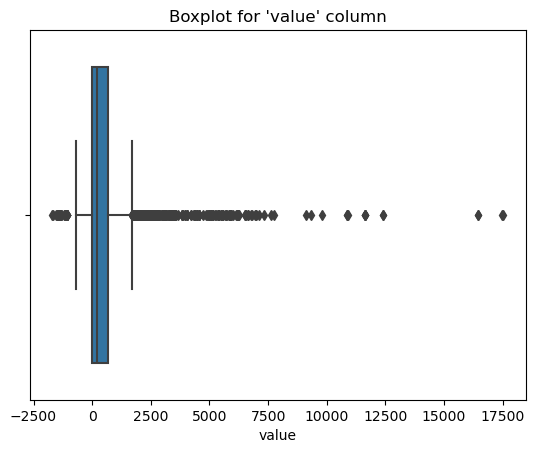

In [492]:
sns.boxplot(x=train_df['value'])
plt.title("Boxplot for 'value' column")
plt.show()


As we can see there are many outliears in our targeted column which can affect out model perfomance so we will use standardization

# Standardization

In [493]:
def standardize_data(train_df, test_df, column_to_standardize):
    scaler = StandardScaler()
    train_df['value_standardized'] = scaler.fit_transform(train_df[[column_to_standardize]])
    test_df['value_standardized'] = scaler.transform(test_df[[column_to_standardize]])
    return train_df, test_df, scaler

train_df, test_df_q32024, scaler_train = standardize_data(train_df, test_df_q32024, 'value')

joblib.dump(scaler_train, 'scaler.joblib')  # Save vectors

['scaler.joblib']

In [494]:
train_df

,text,value,quarter,year,value_standardized
0,Revenue,6164.00,2,2024,3.975117
1,Reported Net Income,1749.00,2,2024,0.797890
2,Adjusted Net Income,1718.00,2,2024,0.775581
3,"Adjusted preprovision, pretax earnings",2690.00,2,2024,1.475075
4,Reported Diluted Earnings Per Share,1.79,2,2024,-0.459478
...,...,...,...,...,...
6504,Commercial Banking and Wealth Management Add: ...,22.00,1,2022,-0.444934
6505,Commercial Banking and Wealth Management Add: ...,29.00,1,2022,-0.439897
6506,Commercial Banking and Wealth Management Prepr...,229.00,1,2022,-0.295968
6507,Commercial Banking and Wealth Management Preta...,13.00,1,2022,-0.451411


# Label Encoding

In [495]:
def label_encode_with_unseen_handling(train_df, test_df, column_name):
    label_encoder = LabelEncoder()
    train_df[f'{column_name}_encoded'] = label_encoder.fit_transform(train_df[column_name])
    unseen_label = -1
    test_df[f'{column_name}_encoded'] = test_df[column_name].apply(
        lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else unseen_label
    )

    return train_df, test_df, label_encoder

train_df, test_df_q32024, label_encoder = label_encode_with_unseen_handling(train_df, test_df_q32024, 'text')

# Model Prediction

In [496]:
class DataSplitter(BaseEstimator, TransformerMixin):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.features], X[self.target]

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    val_metrics = {
        'MSE': mean_squared_error(y_val, y_val_pred),
        'R2': r2_score(y_val, y_val_pred),
        'MAE': mean_absolute_error(y_val, y_val_pred),
    }

    y_test_pred = model.predict(X_test)
    test_metrics = {
        'MSE': mean_squared_error(y_test, y_test_pred),
        'R2': r2_score(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred),
    }

    return val_metrics, test_metrics

# Pipeline setup
def build_pipeline(model, features, target):
    pipeline = Pipeline([
        ('split_data', DataSplitter(features, target)),
        ('model', model)                                
    ])
    return pipeline
    
features = ['text_encoded', 'quarter', 'year'] 
target = 'value_standardized'

X_train_full = train_df[features]
y_train_full = train_df[target]
X_test = test_df_q32024[features]
y_test = test_df_q32024[target]

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror')
}

results = {}
for model_name, model in models.items():
    pipeline = build_pipeline(model, features, target)
    val_metrics, test_metrics = evaluate_model(
        model, X_train, y_train, X_val, y_val, X_test, y_test
    )
    
    results[model_name] = {
        'Validation': val_metrics,
        'Test': test_metrics
    }

for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print(f"  Validation Metrics: {metrics['Validation']}")
    print(f"  Test Metrics: {metrics['Test']}")


Linear Regression Results:
  Validation Metrics: {'MSE': 1.0366929922072416, 'R2': 0.08623750288534426, 'MAE': 0.5265215585616265}
  Test Metrics: {'MSE': 1.6482047859703213, 'R2': 0.07145196003446486, 'MAE': 0.6412049250482255}

Random Forest Results:
  Validation Metrics: {'MSE': 0.1442358054424831, 'R2': 0.8728675984643679, 'MAE': 0.1893236738254847}
  Test Metrics: {'MSE': 0.2485335109808219, 'R2': 0.8599838403265319, 'MAE': 0.2234991581266149}

XGBoost Results:
  Validation Metrics: {'MSE': 0.3636540982704749, 'R2': 0.6794678082909429, 'MAE': 0.2726938316877813}
  Test Metrics: {'MSE': 0.5352478564318991, 'R2': 0.6984577691946203, 'MAE': 0.3523236332527999}


## with hyper parameter tunning

In [497]:
# tfidf_vectorizer = TfidfVectorizer(max_features=5000) 
# X_text_train = tfidf_vectorizer.fit_transform(train_df['text']).toarray()
# X_text_test = tfidf_vectorizer.transform(test_df_q32024['text']).toarray()

# X_train_full = pd.DataFrame(X_text_train).join(train_df[['quarter', 'year']].reset_index(drop=True))
# X_test = pd.DataFrame(X_text_test).join(test_df_q32024[['quarter', 'year']].reset_index(drop=True))

# X_train_full.columns = X_train_full.columns.astype(str)
# X_test.columns = X_test.columns.astype(str)

# y_train_full = train_df['value_standardized']
# y_test = test_df_q32024['value_standardized']

# X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# param_distributions = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2']
# }

# random_forest = RandomForestRegressor(random_state=42)
# random_search = RandomizedSearchCV(
#     estimator=random_forest,
#     param_distributions=param_distributions,
#     n_iter=25,  
#     cv=3,       
#     scoring='neg_mean_squared_error',
#     random_state=42,
#     n_jobs=-1  
# )

# random_search.fit(X_train, y_train)

# best_rf = random_search.best_estimator_
# best_params = random_search.best_params_
# print(f"Best Parameters: {best_params}")

# y_train_pred = best_rf.predict(X_train)
# y_val_pred = best_rf.predict(X_val)
# y_test_pred = best_rf.predict(X_test)

# train_metrics = {
#     'MSE': mean_squared_error(y_train, y_train_pred),
#     'R2': r2_score(y_train, y_train_pred),
#     'MAE': mean_absolute_error(y_train, y_train_pred),
# }

# val_metrics = {
#     'MSE': mean_squared_error(y_val, y_val_pred),
#     'R2': r2_score(y_val, y_val_pred),
#     'MAE': mean_absolute_error(y_val, y_val_pred),
# }

# test_metrics = {
#     'MSE': mean_squared_error(y_test, y_test_pred),
#     'R2': r2_score(y_test, y_test_pred),
#     'MAE': mean_absolute_error(y_test, y_test_pred),
# }

# print("\nRandom Forest with Hyperparameter Tuning Results:")
# print(f"  Training Metrics: {train_metrics}")
# print(f"  Validation Metrics: {val_metrics}")
# print(f"  Test Metrics: {test_metrics}")


### tfidf

In [498]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  
X_text_train = tfidf_vectorizer.fit_transform(train_df['text']).toarray()
X_text_test = tfidf_vectorizer.transform(test_df_q32024['text']).toarray()

X_train_full = pd.DataFrame(X_text_train).join(train_df[['quarter', 'year']].reset_index(drop=True))
X_test = pd.DataFrame(X_text_test).join(test_df_q32024[['quarter', 'year']].reset_index(drop=True))

X_train_full.columns = X_train_full.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

y_train_full = train_df['value_standardized']
y_test = test_df_q32024['value_standardized']

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_metrics = {
        'MSE': mean_squared_error(y_train, y_train_pred),
        'R2': r2_score(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred),
    }

    y_val_pred = model.predict(X_val)
    val_metrics = {
        'MSE': mean_squared_error(y_val, y_val_pred),
        'R2': r2_score(y_val, y_val_pred),
        'MAE': mean_absolute_error(y_val, y_val_pred),
    }

    y_test_pred = model.predict(X_test)
    test_metrics = {
        'MSE': mean_squared_error(y_test, y_test_pred),
        'R2': r2_score(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred),
    }

    return train_metrics, val_metrics, test_metrics

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, objective='reg:squarederror')
}

results = {}
for model_name, model in models.items():
    train_metrics, val_metrics, test_metrics = evaluate_model(
        model, X_train, y_train, X_val, y_val, X_test, y_test
    )
    
    results[model_name] = {
        'Training': train_metrics,
        'Validation': val_metrics,
        'Test': test_metrics
    }

for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print(f"  Training Metrics: {metrics['Training']}")
    print(f"  Validation Metrics: {metrics['Validation']}")
    print(f"  Test Metrics: {metrics['Test']}")



Linear Regression Results:
  Training Metrics: {'MSE': 0.4337251901815559, 'R2': 0.551162235221885, 'MAE': 0.3835725833637841}
  Validation Metrics: {'MSE': 0.5400753670335453, 'R2': 0.5239664782917404, 'MAE': 0.39668846342148184}
  Test Metrics: {'MSE': 0.9093869691355364, 'R2': 0.4876792647681306, 'MAE': 0.48074891375278594}

Random Forest Results:
  Training Metrics: {'MSE': 0.028806679811838685, 'R2': 0.9701895899290234, 'MAE': 0.06987084836233248}
  Validation Metrics: {'MSE': 0.07122725901817305, 'R2': 0.9372188308859839, 'MAE': 0.1302172433996847}
  Test Metrics: {'MSE': 0.10894557793093984, 'R2': 0.9386234018298086, 'MAE': 0.1486634546680199}

XGBoost Results:
  Training Metrics: {'MSE': 0.027808065978486632, 'R2': 0.9712229991267936, 'MAE': 0.07643634958088923}
  Validation Metrics: {'MSE': 0.06227050141580925, 'R2': 0.9451135010094515, 'MAE': 0.12703976728725952}
  Test Metrics: {'MSE': 0.1022318022332767, 'R2': 0.9424057372033607, 'MAE': 0.14577281255095537}


# saving and exporting the model

In [499]:
def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Model saved as {filename}")

save_model(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
save_model(models['Random Forest'], 'random_forest_model.joblib')
save_model(models['XGBoost'], 'xgboost_model.joblib')
joblib.dump(X_text_train, 'train_tfidf_vectors.joblib')  # Save vectors

Model saved as tfidf_vectorizer.joblib
Model saved as random_forest_model.joblib
Model saved as xgboost_model.joblib


['train_tfidf_vectors.joblib']

In [500]:
def load_model(filename):
    return joblib.load(filename)

tfidf_vectorizer_loaded = load_model('tfidf_vectorizer.joblib')
random_forest_loaded = load_model('random_forest_model.joblib')
xgboost_loaded = load_model('xgboost_model.joblib')

print("Models loaded successfully!")


Models loaded successfully!
